## Here I used the Random Classifier to Predict the outcome of the 2025/26 Premier League season

**I took a series of Historical Premier League Season in CSV format, builds summary statistics for each club (points, wins, draws,
losses, goals for/against and goal difference). Then trains a
RandomForestClassifier from scikit‑learn to predict the final league
position of each team in a subsequent season.  The 2025/26 Premier
League will include 20 clubs – the 17 sides that remained in the
division in 2024/25 and three promoted clubs (Leeds United, Burnley
and Sunderland)【177773065645842†screenshot】.  Since results from the
2024/25 campaign are not yet freely available, the model uses the
2023/24 season as the most recent set of training features.  New
clubs that did not compete in 2023/24 are assigned average feature
values based on the bottom three sides from that season.**

The historical match files used by this script can be downloaded from
the open‑source football csv mirror hosted on GitHub.  Each file
(`eng1_2018-19.csv`, `eng1_2019-20.csv`, … `eng1_2023-24.csv`) lists
every Premier League match in the given season with columns for the
date, home side (Team 1), final score (FT), half‑time score (HT) and
away side (Team 2). 

Each CSV contains 380 matches (20 clubs playing 38 games each).  The
script parses the final score to determine home and away goals and
computes win/draw/loss outcomes accordingly.  After summarising the
season, the teams are sorted by points, goal difference and goals
scored to derive a final ranking.  For training data, each team’s
performance statistics from season `n` are used to predict its
position in season `n+1`.  Teams that enter the league via promotion
are assigned default feature values representing the average of the
bottom three clubs from the previous season.

The RandomForestClassifier hyperparameters can be adjusted via the
constants at the bottom of the script.  By default the model uses
100 trees, a maximum depth of 8 and a random seed for reproducible
results.  After training, the script prints the predicted league
table for 2025/26 along with a comparison to the training periods.

In [1]:
import os
from collections import defaultdict
from typing import Dict, List, Tuple

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [6]:
df = pd.read_csv("eng1_2023-24.csv")
df.head()

,Date,Team 1,FT,HT,Team 2
0,Fri Aug 11 2023,Burnley,0-3,0-2,Man City
1,Sat Aug 12 2023,Arsenal,2-1,2-0,Nott'm Forest
2,Sat Aug 12 2023,Bournemouth,1-1,0-0,West Ham
3,Sat Aug 12 2023,Brighton,4-1,1-0,Luton
4,Sat Aug 12 2023,Everton,0-1,0-0,Fulham


In [11]:
# Parse full-time score column into home and away goals
goals = df['FT'].str.split("-", expand=True)

# Create new columns directly in df
df['home_goals'] = goals[0].astype(int)
df['away_goals'] = goals[1].astype(int)
df.head()


# df[["home_goals", "away_goals"]] = df["FT"].str.split("-", expand=True).astype(int) 
## this line is more compact and cleanest

,Date,Team 1,FT,HT,Team 2,home_goals,away_goals
0,Fri Aug 11 2023,Burnley,0-3,0-2,Man City,0,3
1,Sat Aug 12 2023,Arsenal,2-1,2-0,Nott'm Forest,2,1
2,Sat Aug 12 2023,Bournemouth,1-1,0-0,West Ham,1,1
3,Sat Aug 12 2023,Brighton,4-1,1-0,Luton,4,1
4,Sat Aug 12 2023,Everton,0-1,0-0,Fulham,0,1


In [13]:
# To confirm that parsing worked
df[["Team 1", "Team 2", "FT", "home_goals", "away_goals"]].head()

,Team 1,Team 2,FT,home_goals,away_goals
0,Burnley,Man City,0-3,0,3
1,Arsenal,Nott'm Forest,2-1,2,1
2,Bournemouth,West Ham,1-1,1,1
3,Brighton,Luton,4-1,4,1
4,Everton,Fulham,0-1,0,1


In [15]:
matches = df.copy()
matches.head()

,Date,Team 1,FT,HT,Team 2,home_goals,away_goals
0,Fri Aug 11 2023,Burnley,0-3,0-2,Man City,0,3
1,Sat Aug 12 2023,Arsenal,2-1,2-0,Nott'm Forest,2,1
2,Sat Aug 12 2023,Bournemouth,1-1,0-0,West Ham,1,1
3,Sat Aug 12 2023,Brighton,4-1,1-0,Luton,4,1
4,Sat Aug 12 2023,Everton,0-1,0-0,Fulham,0,1


# Determine match outcomes

In [16]:
matches['home_points'] = ((matches['home_goals'] > matches['away_goals']) * 3 + (matches['home_goals'] == matches['away_goals']) * 1)

In [17]:
matches['away_points'] = ((matches['away_goals'] > matches['home_goals']) * 3 + (matches['home_goals'] == matches['away_goals']) * 1)

In [18]:
matches.head()

,Date,Team 1,FT,HT,Team 2,home_goals,away_goals,home_points,away_points
0,Fri Aug 11 2023,Burnley,0-3,0-2,Man City,0,3,0,3
1,Sat Aug 12 2023,Arsenal,2-1,2-0,Nott'm Forest,2,1,3,0
2,Sat Aug 12 2023,Bournemouth,1-1,0-0,West Ham,1,1,1,1
3,Sat Aug 12 2023,Brighton,4-1,1-0,Luton,4,1,3,0
4,Sat Aug 12 2023,Everton,0-1,0-0,Fulham,0,1,0,3


In [21]:
matches['home_win'] = (matches['home_goals'] > matches['away_goals']).astype(int)
matches['away_win'] = (matches['away_goals'] > matches['home_goals']).astype(int)
matches['draw'] = (matches['home_goals'] == matches['away_goals']).astype(int)

# Aggregate stats for home teams

In [23]:
home_stats = matches.groupby('Team 1').agg(
    points=('home_points', 'sum'),
    wins=('home_win', 'sum'),
    draws=('draw', 'sum'),
    losses=('away_win', 'sum'),
    goals_for=('home_goals', 'sum'),
    goals_against=('away_goals', 'sum')
).rename_axis('team')

In [24]:
matches.head()

,Date,Team 1,FT,HT,Team 2,home_goals,away_goals,home_points,away_points,points,home_win,away_win,draw
0,Fri Aug 11 2023,Burnley,0-3,0-2,Man City,0,3,0,3,3,0,1,0
1,Sat Aug 12 2023,Arsenal,2-1,2-0,Nott'm Forest,2,1,3,0,3,1,0,0
2,Sat Aug 12 2023,Bournemouth,1-1,0-0,West Ham,1,1,1,1,2,0,0,1
3,Sat Aug 12 2023,Brighton,4-1,1-0,Luton,4,1,3,0,3,1,0,0
4,Sat Aug 12 2023,Everton,0-1,0-0,Fulham,0,1,0,3,3,0,1,0


# Aggregate stats for away teams

In [25]:
away_stats = matches.groupby('Team 2').agg(
    points=('away_points', 'sum'),
    wins=('away_win', 'sum'),
    draws=('draw', 'sum'),
    losses=('home_win', 'sum'),
    goals_for=('away_goals', 'sum'),
    goals_against=('home_goals', 'sum')
).rename_axis('team')

## Combine home and away stats

In [26]:
summary = home_stats.add(away_stats, fill_value=0).astype(int).reset_index()

## Compute goal difference

In [27]:
summary['goal_diff'] = summary['goals_for'] - summary['goals_against']

## Sort and assign positions

In [28]:
summary = summary.sort_values(
    ['points', 'goal_diff', 'goals_for'], ascending=[False, False, False]
).reset_index(drop=True)
summary['position'] = summary.index + 1

In [29]:
summary.head()

,team,points,wins,draws,losses,goals_for,goals_against,goal_diff,position
0,Man City,91,28,7,3,96,34,62,1
1,Arsenal,89,28,5,5,91,29,62,2
2,Liverpool,82,24,10,4,86,41,45,3
3,Aston Villa,68,20,8,10,76,61,15,4
4,Tottenham,66,20,6,12,74,61,13,5


In [30]:
# Load and summarize seasons
season_files = [
    "eng1_2018-19.csv",
    "eng1_2019-20.csv",
    "eng1_2020-21.csv",
    "eng1_2021-22.csv",
    "eng1_2022-23.csv",
    "eng1_2023-24.csv",
]

In [33]:
season_summaries = {}
for file in season_files:
    df = pd.read_csv(file)
    df[["home_goals", "away_goals"]] = df["FT"].str.split("-", expand=True).astype(int) 
      # --- Vectorized season summary ---
    # Determine outcomes
    df['home_points'] = (df['home_goals'] > df['away_goals']) * 3 + (df['home_goals'] == df['away_goals']) * 1
    df['away_points'] = (df['away_goals'] > df['home_goals']) * 3 + (df['away_goals'] == df['home_goals']) * 1
    df['home_win'] = (df['home_goals'] > df['away_goals']).astype(int)
    df['away_win'] = (df['away_goals'] > df['home_goals']).astype(int)
    df['draw'] = (df['home_goals'] == df['away_goals']).astype(int)

    # Aggregate home stats
    home_stats = df.groupby('Team 1').agg(
        points=('home_points', 'sum'),
        wins=('home_win', 'sum'),
        draws=('draw', 'sum'),
        losses=('away_win', 'sum'),
        goals_for=('home_goals', 'sum'),
        goals_against=('away_goals', 'sum')
    ).rename_axis('team')

    # Aggregate away stats
    away_stats = df.groupby('Team 2').agg(
        points=('away_points', 'sum'),
        wins=('away_win', 'sum'),
        draws=('draw', 'sum'),
        losses=('home_win', 'sum'),
        goals_for=('away_goals', 'sum'),
        goals_against=('home_goals', 'sum')
    ).rename_axis('team')

    # Combine home and away stats
    summary = home_stats.add(away_stats, fill_value=0).astype(int)
    summary['goal_diff'] = summary['goals_for'] - summary['goals_against']

    # Sort and assign positions
    summary = summary.sort_values(['points', 'goal_diff', 'goals_for'], ascending=[False, False, False])
    summary['position'] = range(1, len(summary) + 1)

    season_summaries[file] = summary
    

In [34]:
# Build training dataset
# -----------------------------
X_train, y_train = [], []

for prev_file, next_file in zip(season_files, season_files[1:]):
    prev, curr = season_summaries[prev_file], season_summaries[next_file]
    default_feats = prev.nsmallest(3, ["points","goal_diff","goals_for"]).mean()
    
    feats = curr.index.to_series().apply(
        lambda t: prev.loc[t, ["points","wins","draws","losses","goals_for","goals_against","goal_diff"]].to_dict()
        if t in prev.index else default_feats[["points","wins","draws","losses","goals_for","goals_against","goal_diff"]].to_dict()
    )
    
    X_train.extend(feats.tolist())
    y_train.extend(curr["position"].tolist())

X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# -----------------------------
# Prepare latest features
# -----------------------------
last = season_summaries[season_files[-1]]
default_last = last.nsmallest(3, ["points","goal_diff","goals_for"]).mean()
promoted = ["Leeds United","Burnley","Sunderland"]

latest_features = pd.DataFrame(
    [last.loc[t, ["points","wins","draws","losses","goals_for","goals_against","goal_diff"]].to_dict()
     if t in last.index else default_last[["points","wins","draws","losses","goals_for","goals_against","goal_diff"]].to_dict()
     for t in list(last.index) + promoted],
    index=list(last.index) + promoted
)

# -----------------------------
# Train model
# -----------------------------
model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, class_weight="balanced"))
])
model.fit(X_train, y_train)

# -----------------------------
# Predict league table
# -----------------------------
probas = model.predict_proba(latest_features)
classes = model.named_steps["rf"].classes_
exp_positions = probas.dot(classes)

predictions = pd.DataFrame({
    "team": latest_features.index,
    "expected_position": exp_positions
}).sort_values("expected_position").reset_index(drop=True)

predictions["predicted_rank"] = predictions.index + 1
predictions = predictions.iloc[:20]

# -----------------------------
# Display results
# -----------------------------
for _, row in predictions.iterrows():
    print(f"{int(row['predicted_rank'])}. {row['team']} (expected pos {row['expected_position']:.2f})")


1. Arsenal (expected pos 1.43)
2. Man City (expected pos 2.23)
3. Liverpool (expected pos 4.59)
4. Tottenham (expected pos 6.15)
5. Aston Villa (expected pos 6.37)
6. Chelsea (expected pos 6.79)
7. Newcastle (expected pos 7.91)
8. Man United (expected pos 8.94)
9. Everton (expected pos 11.32)
10. Brentford (expected pos 12.05)
11. Brighton (expected pos 12.34)
12. Crystal Palace (expected pos 12.58)
13. Wolves (expected pos 12.69)
14. Nott'm Forest (expected pos 12.71)
15. Bournemouth (expected pos 12.92)
16. Fulham (expected pos 13.82)
17. West Ham (expected pos 14.83)
18. Sheffield United (expected pos 15.19)
19. Leeds United (expected pos 15.96)
20. Sunderland (expected pos 15.96)


C:\Users\USER\AppData\Local\Temp\ipykernel_14880\2050164497.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="expected_position", y="team", data=predictions, palette="viridis")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\USER\\ML fun projects\\PL_2025_ML_Predictor\\results\\predicted_league_table.png'

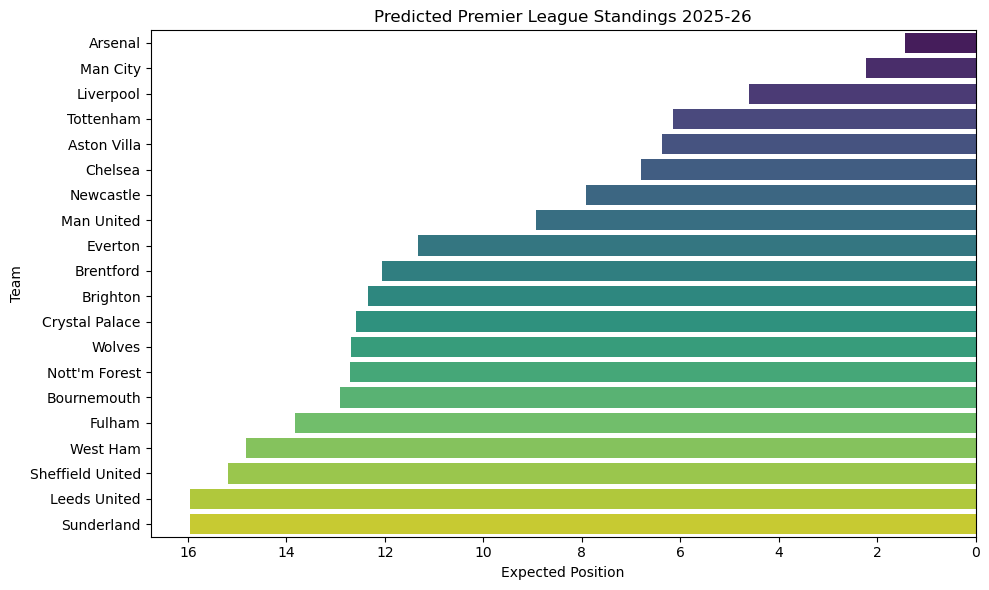

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x="expected_position", y="team", data=predictions, palette="viridis")
plt.xlabel("Expected Position")
plt.ylabel("Team")
plt.title("Predicted Premier League Standings 2025-26")
plt.gca().invert_xaxis()  # lower position = better
plt.tight_layout()
plt.savefig("results/predicted_league_table.png")
plt.show()
